# CS5814: Assignment 4

## Problem 4

In problem involves using the REINFORCE policy gradient algorithim to solve the Acrobot OpenAI environment.

Details of the environment can be found here: https://gym.openai.com/envs/Acrobot-v1/

## Imports

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Supporting functions

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

In [12]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [4]:
def simulation(gym_env, policy_net, episodes=100):
  # a simulation of number of episodes based on trianed policy to determine performance

  episode_lengths = []
  env = gym.make(gym_env)

  for episode in tqdm(range(episodes)):

          state = env.reset()

          for step in range(500):

              action_probs = get_action(policy_net, state)  # Get action distribution from policy
              action_dist = torch.distributions.Categorical(probs=action_probs)  # Create distribution from action probs
              action = action_dist.sample()
              state_next, reward, done, info = env.step(action.item())  # Take action in environment

              state = state_next
              if done:
                  break
          
          episode_lengths.append(step)

  print(np.average(episode_lengths))


In [13]:
def plot_moving_average(rewards):

    plt.figure(figsize=(8,6))
    plt.plot(rewards, label="Individual", linewidth=1.5)
    plt.plot(running_mean(rewards, 10), label="Averaged", linewidth=1.5)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.legend()
    plt.grid()
    plt.show()

## Policy gradient supporting function

In [5]:
def get_action(policy, state):
    """Probability distribution of actions in given state"""

    state = torch.tensor(state).to(device)

    return policy(state)

In [6]:
def cumulative_rewards(rewards, gamma):
    """Calculating cumulative sum of future discounted rewards"""

    discounted_rewards = []
    for t in range(len(rewards)):
        G = 0
        for k, r, in enumerate(rewards[t:]):
            G += (gamma ** k) * r
        discounted_rewards.append(G)

    return discounted_rewards

## Policy network

In [7]:
class PolicyGrad(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyGrad, self).__init__()

        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim

        self.l1 = nn.Linear(self.state_dim, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, self.action_dim)
        self.act = nn.ReLU()
        self.output = nn.Softmax(dim=-1)

    def forward(self, x):

        x = x.float()  # Not sure if this is needed now

        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.output(x)

        return x

## Training Loop

In [8]:
def training_instance(gym_env, episodes, alpha,
                      gamma, max_steps=500, batch_size=1,
                      seed=None):
    """
    Run a singular instance of training (eg multiple episodes until environment is solved, or max episodes reached)
    """

    env = gym.make(gym_env)

    if seed is not None:
        #env.reset(seed=seed) - this doesnt work in colab, wrong gym version?
        pass

    policy_net = PolicyGrad(env.observation_space.shape[0], 100, env.action_space.n).to(device)
    policy_net = policy_net.float()
    policy_net.apply(init_weights)
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=alpha)

    episode_lengths = []
    render_flag = False
    for episode in range(episodes):

        net_reward = 0
        state = env.reset()
        state_array, action_array, reward_array = [], [], []

        for step in range(max_steps):

            action_probs = get_action(policy_net, state)  # Get action distribution from policy
            action_dist = torch.distributions.Categorical(probs=action_probs)  # Create distribution from action probs
            action = action_dist.sample()
            state_next, reward, done, info = env.step(action.item())  # Take action in environment

            # Tracking state, action, rewards and states visited
            state_array.append(state)
            action_array.append(action)
            reward_array.append(reward)

            # Accumulate reward and move to next state
            net_reward += reward
            state = state_next

            if render_flag:
                env.render()

            if done:
                break

        # Update agents policy based on prior trajectory #TODO - extend to batched episodes
        discounted_returns = cumulative_rewards(reward_array, gamma)

        for state, action, G in zip(state_array, action_array, discounted_returns):
            action_probs = get_action(policy_net, state)  # Get action probs
            action_dist = torch.distributions.Categorical(probs=action_probs)  # Create distribution from action probs
            log_prob = action_dist.log_prob(action)  # Find prob of action in distribution
            loss = -log_prob * G  # Calculate loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        episode_lengths.append(step+1)

        # Trigger to render good runs (currently disabled)
        if np.average(episode_lengths[-10:]) < 100 and episode > 50 and False:
            render_flag = True

        print("Episode: {0}, Steps:{1:.2f}".format(episode, episode_lengths[-1]))

    env.close()
    plt.plot(episode_lengths)
    plt.show()

    return episode_lengths, policy_net

## Training Configuration

In [9]:
def run_individual():
    """ Run training instances to completion (until environment is solved or max episodes reached)"""

    gym_env = 'Acrobot-v1'

    # Set to run once with the random seed 0

    # Hyperparameter
    alpha = 0.0001
    gamma = 0.999
    max_episodes = 500
    batch_size = 1
    seed = 3

    np.random.seed(seed)
    torch.manual_seed(seed)

    print("Starting trainig run""")

    episode_rewards, policy_net = training_instance(gym_env=gym_env,
                                        episodes=max_episodes,
                                        alpha=alpha,
                                        gamma=gamma,
                                        max_steps=500,
                                        batch_size=batch_size,
                                        seed=seed)
    
    return gym_env, episode_rewards, policy_net

Starting trainig run
Episode: 0, Steps:500.00
Episode: 1, Steps:500.00
Episode: 2, Steps:340.00
Episode: 3, Steps:500.00
Episode: 4, Steps:335.00
Episode: 5, Steps:444.00
Episode: 6, Steps:342.00
Episode: 7, Steps:491.00
Episode: 8, Steps:313.00
Episode: 9, Steps:267.00
Episode: 10, Steps:136.00
Episode: 11, Steps:458.00
Episode: 12, Steps:220.00
Episode: 13, Steps:186.00
Episode: 14, Steps:193.00
Episode: 15, Steps:296.00
Episode: 16, Steps:223.00
Episode: 17, Steps:160.00
Episode: 18, Steps:188.00
Episode: 19, Steps:275.00
Episode: 20, Steps:160.00
Episode: 21, Steps:351.00
Episode: 22, Steps:277.00
Episode: 23, Steps:205.00
Episode: 24, Steps:200.00
Episode: 25, Steps:165.00
Episode: 26, Steps:146.00
Episode: 27, Steps:141.00
Episode: 28, Steps:186.00
Episode: 29, Steps:165.00
Episode: 30, Steps:152.00
Episode: 31, Steps:147.00
Episode: 32, Steps:180.00
Episode: 33, Steps:171.00
Episode: 34, Steps:137.00
Episode: 35, Steps:185.00
Episode: 36, Steps:203.00
Episode: 37, Steps:205.00
E

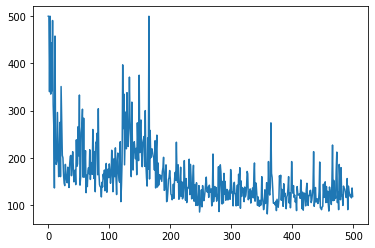

In [10]:
env, episode_lengths, policy_net = run_individual()

In [11]:
simulation(env, policy_net, episodes=100)

100%|██████████| 100/100 [00:08<00:00, 12.45it/s]

117.97


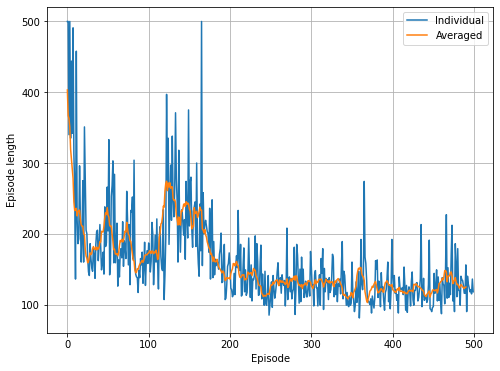

In [14]:
plot_moving_average(episode_lengths)